In [1]:
import cartopy.crs as ccrs
import csv
from dataclasses import asdict
from datetime import datetime, timedelta
import easygems.healpix as egh
from importlib import reload
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, find_ec_lon
import pandas as pd

In [2]:
# Define dates for forecast initialization and flight
# Airport Restrictions. None for 18.8.
# Meet EarthCARE South of ITCZ or in the South of the ITCZ (if there is less clouds)  (Silke)

issued_time = datetime(2024, 8, 14,0, 0, 0)   # ???
issued_time_str = issued_time.strftime('%Y-%m-%d')

flight_time = datetime(2024, 8, 18, 10, 0, 0)         # ??? start date and time
flight_time_str = flight_time.strftime('%Y-%m-%d')
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print("Initalization date of IFS forecast: " + issued_time_str + "\nFlight date: " + flight_time_str + "\nFlight index: " + flight_index)

Initalization date of IFS forecast: 2024-08-14
Flight date: 2024-08-18
Flight index: HALO-20240818a


In [3]:
# Domain definition
# TO DO: replace by global definition once it exists
lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

In [4]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(refdate="2024-08-15",reftime="00").to_dask().pipe(egh.attach_coords)   # ???

In [5]:
# Load ec satellite track for 
track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-16", kind="PRE").get_track_for_day(flight_time_str)
track = track.sel(time=slice(flight_time_str + " 06:00", None))
ec_lons, ec_lats = track.lon.values, track.lat.values

**Waypoint definitions**

In [6]:
track.lat

<xarray.DataArray 'lat' (time: 18)> Size: 144B
array([21.3567, 20.0637, 18.7703, 17.4766, 16.1826, 14.8882, 13.5936,
       12.2988, 11.0037,  9.7085,  8.4131,  7.1175,  5.8219,  4.5262,
        3.2305,  1.9348,  0.639 , -0.6567])
Coordinates:
  * time     (time) datetime64[ns] 144B 2024-08-18T16:00:14 ... 2024-08-18T16...

In [7]:
track.time

<xarray.DataArray 'time' (time: 18)> Size: 144B
array(['2024-08-18T16:00:14.000000000', '2024-08-18T16:00:34.000000000',
       '2024-08-18T16:00:54.000000000', '2024-08-18T16:01:14.000000000',
       '2024-08-18T16:01:34.000000000', '2024-08-18T16:01:54.000000000',
       '2024-08-18T16:02:14.000000000', '2024-08-18T16:02:34.000000000',
       '2024-08-18T16:02:54.000000000', '2024-08-18T16:03:14.000000000',
       '2024-08-18T16:03:34.000000000', '2024-08-18T16:03:54.000000000',
       '2024-08-18T16:04:14.000000000', '2024-08-18T16:04:34.000000000',
       '2024-08-18T16:04:54.000000000', '2024-08-18T16:05:14.000000000',
       '2024-08-18T16:05:34.000000000', '2024-08-18T16:05:54.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 144B 2024-08-18T16:00:14 ... 2024-08-18T16...

In [8]:
# Mass flux circle radius (m)
radius = 100e3

In [9]:
# ITCZ edges visually estimated from iwv contours

lat_edge_south = 3.0    # ???
lat_edge_north = 13.1   # ???

In [10]:
# ?
band = "east"

airport = sal if band == "east" else bco

# Point where we enter ec track? visually estimated? Rename to "lat_track_entry_north"?
lat_north = 14.0 # 10th percentile     #???
lat_south = 3.0 # 5th percentile - 1°  #??? 

In [11]:
# Setting lat/lon coordinates

# Points where we get on ec track?
north = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), "north")
south = LatLon(lat_south, find_ec_lon(lat_south, ec_lons, ec_lats), "south")

# Intersection of ITCZ edges with ec track
edge_north = LatLon(lat_edge_north, find_ec_lon(lat_edge_north, ec_lons, ec_lats), "edge_north")
edge_south = LatLon(lat_edge_south, find_ec_lon(lat_edge_south, ec_lons, ec_lats), "edge_south")

# Center of middle circle
center = edge_south.towards(edge_north).assign_label("center")

# Southern return point
returnPoint = north if band == "east" else LatLon(bco.lat, -53.0, "")


# What does leg refer to?
leg_south = [
     airport,
     north,
     edge_north,
     center,
     edge_south,
     south
]

leg_circles = [
     IntoCircle(edge_south, radius, 360),
     IntoCircle(center, radius, 360),
     IntoCircle(edge_north, radius, 360),
]
    
leg_home = [
     north,
     airport
]

waypoints = leg_south + leg_circles + leg_home 

path = fp.expand_path(waypoints, dx=10e3)

#print(f"duration: {halo_flight_duration(path)}")

In [12]:
path.distance

<xarray.DataArray 'distance' (distance: 648)> Size: 5kB
array([      0.      ,    9896.980128,   19793.960257, ..., 5645743.999971,
       5655640.980099, 5665537.960228])
Coordinates:
  * distance  (distance) float64 5kB 0.0 9.897e+03 ... 5.656e+06 5.666e+06
    lon       (distance) float64 5kB -22.94 -23.03 -23.11 ... -23.03 -22.94
    lat       (distance) float64 5kB 16.73 16.69 16.65 ... 16.65 16.69 16.73
    fl        (distance) float64 5kB nan nan nan nan nan ... nan nan nan nan 0.0

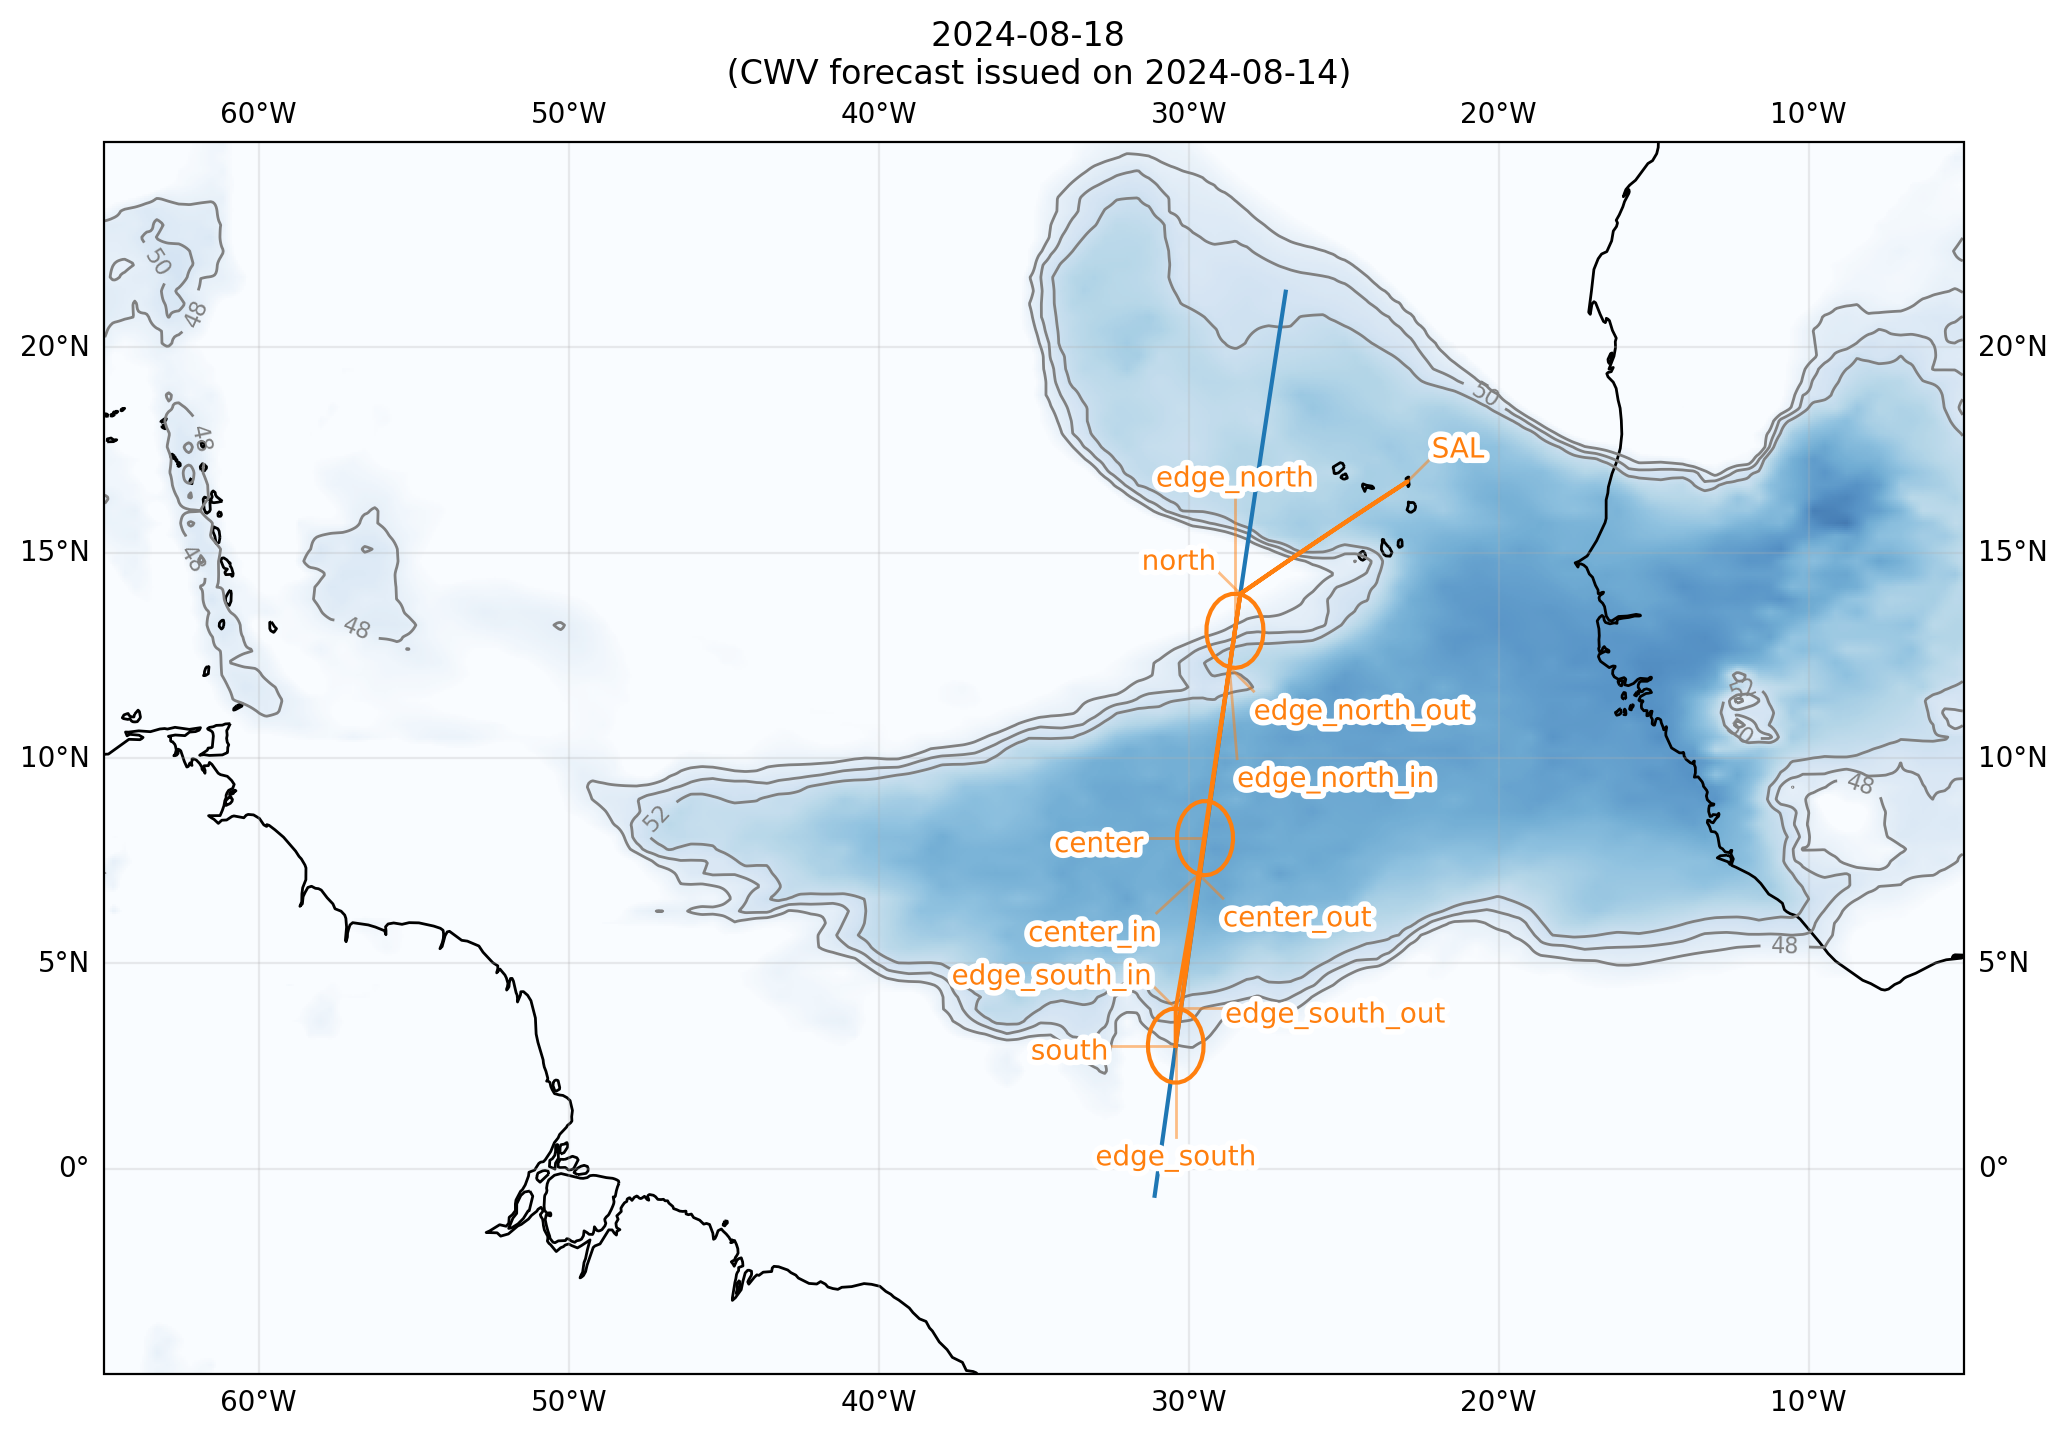

In [13]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)


cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [48.0, 50.0, 52.0])
plt.title(f"{flight_time_str} \n (CWV forecast issued on {issued_time_str})")

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")

In [14]:
pd.DataFrame.from_records(map(asdict, [north, edge_north, center, edge_south, south])).set_index("label")

,lat,lon,fl
label,,,
north,14.000000,-28.336581,None
edge_north,13.100000,-28.510614,None
center,8.051728,-29.477000,None
edge_south,3.000000,-30.419680,None
south,3.000000,-30.419680,None


In [15]:
path

<xarray.Dataset> Size: 32kB
Dimensions:           (waypoint: 14, distance: 648)
Coordinates:
  * distance          (distance) float64 5kB 0.0 9.897e+03 ... 5.666e+06
    lon               (distance) float64 5kB -22.94 -23.03 ... -23.03 -22.94
    lat               (distance) float64 5kB 16.73 16.69 16.65 ... 16.69 16.73
    fl                (distance) float64 5kB nan nan nan nan ... nan nan nan 0.0
Dimensions without coordinates: waypoint
Data variables:
    waypoint_indices  (waypoint) int64 112B 0 66 77 134 191 ... 473 560 581 647
    waypoint_labels   (waypoint) <U14 784B 'SAL' 'north' ... 'north' 'SAL'
    speed             (distance) float64 5kB nan nan nan nan ... nan nan 180.7
    duration          (distance) timedelta64[ns] 5kB 00:00:00 NaT ... NaT NaT